In [2]:
import pygmt
import numpy as np
import os
import pandas as pd
from pyrocko import util, model, io, trace, gmtpy
import pyrocko.moment_tensor as pmt
from pyrocko.plot import beachball
import matplotlib.pyplot as plt

workdir='../'
catdir =  os.path.join(workdir,'CAT')

switch_VLP=False         ###SWITCH###

if switch_VLP:
    clustydir='../../clusty_flegrei/results_VLP'    
else:
    clustydir='../../clusty_flegrei/results_VT_2'   

clusty_filename= os.path.join(clustydir,'cat_trimmed_mean_ccs_dbscan_comb_0.150_3.yaml')  ###CHANGE###
           
clusty_events = model.load_events(clusty_filename)

### Open clusty results

In [3]:
cluster_number=[]
cluster_color=[]
for ev in clusty_events:
    if not ev.extras['cluster_number'] in cluster_number:
        cluster_number.append(ev.extras['cluster_number'])
        cluster_color.append(ev)

cls = {key: [] for key in cluster_number}
for ev in clusty_events:
    cls[ev.extras['cluster_number']].append(ev.moment_tensor)

cls_color = {key: [] for key in cluster_number}
for color in cluster_color:
    cls_color[color.extras['cluster_number']].append(color.extras['color'])

if not switch_VLP:
    del cls[-1]     #remove ev not clustered, only for VT
    del cls_color[-1]

for key in cls:
    print(f'cluster {key} with n ev = {len(cls[key])}')
    print(f'cluster {key} with color {cls_color[key]}\n')

cluster 0 with n ev = 18
cluster 0 with color ['#00A08B']

cluster 2 with n ev = 12
cluster 2 with color ['#6A76FC']

cluster 1 with n ev = 19
cluster 1 with color ['#FD3216']

cluster 4 with n ev = 11
cluster 4 with color ['#620042']

cluster 3 with n ev = 4
cluster 3 with color ['#FF9616']

cluster 5 with n ev = 6
cluster 5 with color ['#328a3e']



### KAGAN moment tensor for each cluster VT

In [4]:
switch_calculate_kagan=True                            ###SWITCH###                       

if switch_calculate_kagan:

    cls_ev = {key: [] for key in cluster_number}
    for ev in clusty_events:
        cls_ev[ev.extras['cluster_number']].append(ev)
    del cls_ev[-1] 
    
    kagan_score_clusters= {key: [] for key in cluster_number}
    del kagan_score_clusters[-1] 
    for key in kagan_score_clusters:
        for ev1 in cls_ev[key]:
            total=0
            n_ev=1
            for ev2 in cls_ev[key]:
                total += pmt.kagan_angle(ev1.moment_tensor, ev2.moment_tensor)
                n_ev += 1
            kagan_score_clusters[key].append( [ [ev1.name ] , [ total/n_ev ] ] )
        kagan_score_clusters[key].sort(key=lambda x: x[1], reverse=False)
    
    for key in kagan_score_clusters:
        print(f'for cluster {key} the event selected is {kagan_score_clusters[key][0][0]} with kagan value :{kagan_score_clusters[key][0][1]}')

for cluster 0 the event selected is ['flegrei_2023_10_02_20_08_26'] with kagan value :[36.83136653018192]
for cluster 2 the event selected is ['flegrei_2025_02_17_16_53_24'] with kagan value :[26.3503826176656]
for cluster 1 the event selected is ['flegrei_2023_06_15_15_39_40'] with kagan value :[30.335376051180077]
for cluster 4 the event selected is ['flegrei_2024_01_21_09_35_04'] with kagan value :[27.72085344415196]
for cluster 3 the event selected is ['flegrei_2023_03_13_22_40_53'] with kagan value :[13.938431368381824]
for cluster 5 the event selected is ['flegrei_2023_09_27_01_35_34'] with kagan value :[35.82703321703532]


### manually adding Kagan events to new catalogue, then open it

In [5]:
if switch_VLP:
    cat_kagan_filename=os.path.join(catdir,'catalogue_flegrei_MT_final_kagan_VLP.pf')
else:
    cat_kagan_filename=os.path.join(catdir,'catalogue_flegrei_MT_final_kagan.pf')

cat_kagan=model.load_events(cat_kagan_filename)

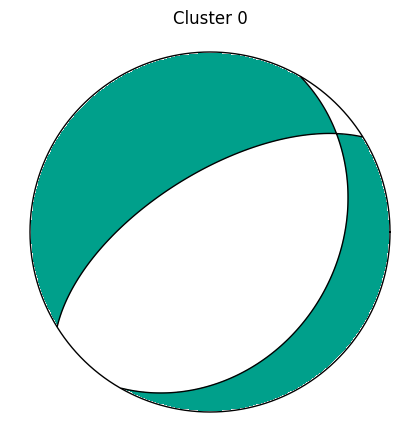

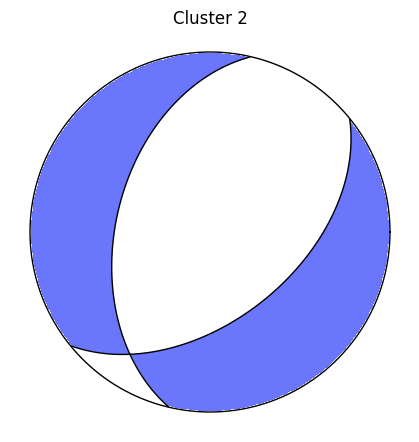

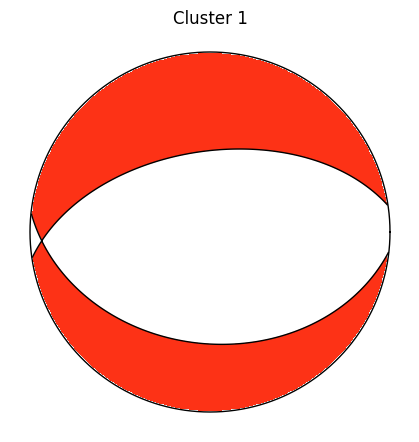

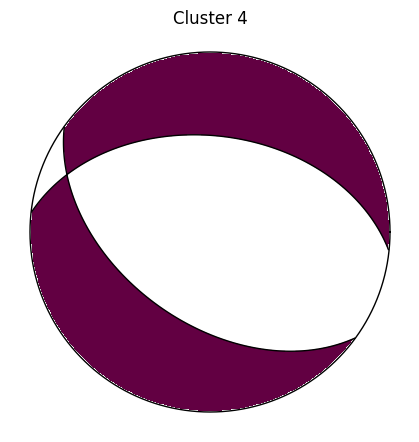

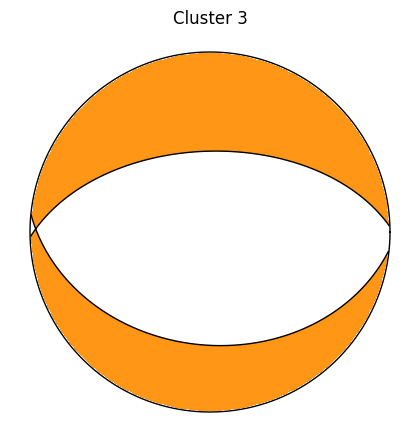

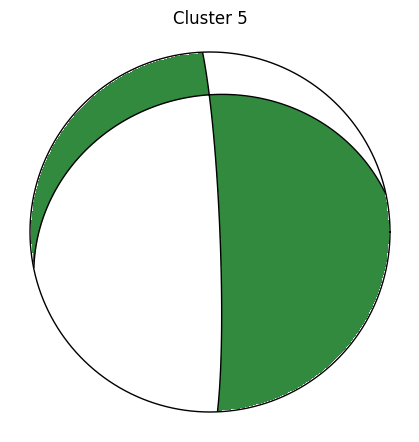

In [7]:
for i,key in enumerate(cls):
    fig = plt.figure(figsize=(4., 4.))
    fig.subplots_adjust(left=0., right=1., bottom=0., top=1.)
    axes = fig.add_subplot(1, 1, 1)

    plot_kwargs = {
        'beachball_type': 'dc',
        'size': 9,
        'position': (5, 5),
        'color_t': cls_color[key][0], #'grey',
        'color_p':'white',
        'edgecolor': 'black',
        'best_color':'black',
        'linewidth':1, 
        'grid_resolution':800
        }
    
    switch_beachball_kagan_only=True

    if switch_beachball_kagan_only:
        # only kagan MT
        beachball.plot_fuzzy_beachball_mpl_pixmap([cat_kagan[i].moment_tensor], axes,best_mt=cat_kagan[i].moment_tensor, **plot_kwargs)
        # Decorate the axes
        axes.set_xlim(0., 10.)
        axes.set_ylim(0., 10.)
        axes.set_axis_off()
        axes.set_title(f'Cluster {key}')
        # save
        fig.savefig(f'../PLOTS/FUZZY_MT/kagan_mt_cluster_{key}.pdf')
    else:
        beachball.plot_fuzzy_beachball_mpl_pixmap(cls[key], axes,best_mt=cat_kagan[i].moment_tensor, **plot_kwargs)
        axes.set_xlim(0., 10.)
        axes.set_ylim(0., 10.)
        axes.set_axis_off()
        axes.set_title(f'Cluster {key}')
        # save
        #fig.savefig(f'../PLOTS/FUZZY_MT/fuzzy_mt_cluster_{key}.pdf')


plt.show()

# Percentage of DC component

In [17]:
cat_filename=os.path.join(catdir,'catalogue_flegrei_MT_final.pf')

cat=model.load_events(cat_filename)

nonDC=[]
count_ev=0
percentage=50
mag=[]
for ev in cat:
    decomposition=ev.moment_tensor.standard_decomposition()
    (moment_iso, ratio_iso, m_iso)=decomposition[0]
    (moment_dc, ratio_dc, m_dc)=decomposition[1]
    (moment_clvd, ratio_clvd, m_clvd)=decomposition[2]
    (moment_devi, ratio_devi, m_devi)=decomposition[3]

    #print(f'iso: {ratio_iso*100:3.3}% , dc: {ratio_dc*100:3.3}% , clvd: {ratio_clvd*100:3.3}% total: {((ratio_iso+ratio_dc+ratio_clvd)*100):4.4}')
    #print(f'devi: {ratio_devi*100:4.4}% --- non DC pecentage= {(1-ratio_dc)*100:3.3}%\n')
    
    nonDC.append((1-ratio_dc)*100)
    if (ratio_clvd)*100>percentage:
        count_ev+=1
        print(f'{ev.name} --- non DC : {(1-ratio_dc)*100:3.3}% --- CLVD : {ratio_clvd*100:3.3}%')
print(f'total events with non CD component>{percentage}  = {count_ev}')


mean_nonDC=np.mean(nonDC)
std_nonDC=np.std(nonDC)
max_nonDC=np.max(nonDC)
min_nonDC=np.min(nonDC)

print(f'\nmean non DC: {mean_nonDC:3.4} +- {std_nonDC:3.4}')
print(f'max non DC: {max_nonDC:3.4} min non DC: {min_nonDC:3.4}')

flegrei_2018_09_18_21_36_41 --- non DC : 76.4% --- CLVD : 76.4%
flegrei_2019_12_06_00_17_23 --- non DC : 54.4% --- CLVD : 54.4%
flegrei_2022_03_29_17_45_32 --- non DC : 79.8% --- CLVD : 79.8%
flegrei_2023_02_05_00_45_36 --- non DC : 64.5% --- CLVD : 64.5%
flegrei_2023_05_08_02_28_34 --- non DC : 65.2% --- CLVD : 65.2%
flegrei_2023_09_12_02_28_50 --- non DC : 53.3% --- CLVD : 53.3%
flegrei_2023_09_26_07_10_29 --- non DC : 56.1% --- CLVD : 56.1%
flegrei_2023_10_04_08_46_55 --- non DC : 60.1% --- CLVD : 60.1%
flegrei_2023_11_23_18_41_46 --- non DC : 92.9% --- CLVD : 92.9%
flegrei_2024_02_17_18_09_50 --- non DC : 69.0% --- CLVD : 69.0%
flegrei_2024_04_04_05_14_36 --- non DC : 58.6% --- CLVD : 58.6%
flegrei_2024_04_14_07_57_58 --- non DC : 60.3% --- CLVD : 60.3%
flegrei_2024_04_14_08_01_43 --- non DC : 69.2% --- CLVD : 69.2%
flegrei_2024_04_27_03_44_56 --- non DC : 51.7% --- CLVD : 51.7%
flegrei_2024_05_20_19_55_37 --- non DC : 79.9% --- CLVD : 79.9%
flegrei_2024_05_22_06_28_00 --- non DC :

In [44]:
cat_filename=os.path.join(catdir,'catalogue_flegrei_MT_final_FULL.pf')
cat=model.load_events(cat_filename)

nonDC=[]
count_ev=0
percentage=50
mag=[]
for ev in cat:
    decomposition=ev.moment_tensor.standard_decomposition()
    (moment_iso, ratio_iso, m_iso)=decomposition[0]
    (moment_dc, ratio_dc, m_dc)=decomposition[1]
    (moment_clvd, ratio_clvd, m_clvd)=decomposition[2]
    (moment_devi, ratio_devi, m_devi)=decomposition[3]

    #print(f'iso: {ratio_iso*100:3.3}% , dc: {ratio_dc*100:3.3}% , clvd: {ratio_clvd*100:3.3}% total: {((ratio_iso+ratio_dc+ratio_clvd)*100):4.4}')
    #print(f'devi: {ratio_devi*100:4.4}% --- non DC pecentage= {(1-ratio_dc)*100:3.3}%\n')
    
    nonDC.append((1-ratio_dc)*100)
    if (ratio_clvd)*100>percentage:
        count_ev+=1
        print(f'{ev.name} --- non DC : {(1-ratio_dc)*100:3.3}% --- ISO : {ratio_iso*100:3.3}%  --- CLVD (difference) : {ratio_clvd*100:3.3}%')
print(f'total events with CLVD component>{percentage}  = {count_ev}')


mean_nonDC=np.mean(nonDC)
std_nonDC=np.std(nonDC)
max_nonDC=np.max(nonDC)
min_nonDC=np.min(nonDC)

print(f'\nmean non DC: {mean_nonDC:3.4} +- {std_nonDC:3.4}')
print(f'max non DC: {max_nonDC:3.4} min non DC: {min_nonDC:3.4}')

flegrei_2019_12_06_00_17_23 --- non DC : 88.2% --- ISO : 0.577%  --- CLVD (difference) : 87.6%
flegrei_2023_01_19_08_44_30 --- non DC : 86.5% --- ISO : 30.2%  --- CLVD (difference) : 56.3%
flegrei_2023_03_04_13_15_20 --- non DC : 89.2% --- ISO : 35.5%  --- CLVD (difference) : 53.7%
flegrei_2023_04_23_00_35_20 --- non DC : 81.1% --- ISO : 19.7%  --- CLVD (difference) : 61.5%
flegrei_2023_05_08_02_28_34 --- non DC : 83.3% --- ISO : 23.5%  --- CLVD (difference) : 59.8%
flegrei_2023_05_08_22_33_17 --- non DC : 72.6% --- ISO : 11.9%  --- CLVD (difference) : 60.6%
flegrei_2023_10_04_08_46_55 --- non DC : 64.7% --- ISO : 5.05%  --- CLVD (difference) : 59.6%
flegrei_2023_10_16_10_36_21 --- non DC : 58.7% --- ISO : 1.06%  --- CLVD (difference) : 57.6%
flegrei_2024_02_17_18_09_50 --- non DC : 80.3% --- ISO : 21.4%  --- CLVD (difference) : 58.9%
flegrei_2024_03_03_09_01_59 --- non DC : 77.5% --- ISO : 23.1%  --- CLVD (difference) : 54.4%
flegrei_2024_04_14_07_57_58 --- non DC : 87.7% --- ISO : 23